In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    # 'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)

def generate_colormap_matrix(colormap_name, size):
    cmap = plt.get_cmap(colormap_name)
    norm = plt.Normalize(0, size - 1)

    colors = cmap(norm(range(size)))
    colors = np.reshape(colors, (size, 4))

    return colors

# Data Import

In [2]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)

# The Model

1. The farmer seeks to optimize the use of fertilizer ($F_{i,t}$) by maximizing a utility function ($\mathcal{U}_{i,t}$). The utility function is a combination of expected profits ($\hat{\mathcal{P}}_{i,t}$) and inertia ($\hat{\mathcal{I}}_{i,t}$), reflecting the farmer's resistance to change based on past experiences.

    $$
        F_{i,t} = \max_{F} \left\{\mathcal{U}_{i,t} \right\} = 
         \max_{F} \left\{\hat{\mathcal{P}}_{i,t}(F) + \kappa_{i,t} \hat{\mathcal{I}}_{i,t}(F)\right\} \quad \quad \kappa_{i,t}\in[0,1]
    $$

    Expected profits are computed using forecasted market prices ($\hat{p}_{i,t} = p_{i,t-1}$), production output ($L_{i,t} y(F)$), and various costs, including fertilizer cost ($p_{\text{F}} F$), operational costs ($p_{\text{O}}$), and non-operational costs ($p_{NO}$):

    $$
        \hat{\mathcal{P}}_{i,t}(F) = \hat{p}_{i,t}   - L_{i,t}( p_{\text{F}} F + p_{\text{O}}) - p_{\text{NO}}
    $$

    The inertia term ($\mathcal{I}_{i,t}$) penalizes deviations between expected revenues and previous revenues:

    $$
    \mathcal{I}_{i,t} =  \max\Big( \hat{p}_{i,t} L_{i,t} y(F) - p_{i,t-1}\alpha_{i,t-1}Y_{i,t-1}, 0 \Big)
    $$

    where $\alpha_{i,t} = \min \left(1, \frac{D_{i,t}}{Y_{i,t}} \right)$ represents the fraction of production sold to the market.

    The degree of inertia ($\kappa_{i,t}$) evolves over time based on the amount of goods sold in the market:

    $$
    \kappa_{i,t} = (1 - \omega) \kappa_{i,t-1} + \omega \lfloor \alpha_{i,t-1} \rfloor 
    $$

    This equation indicates that the inertia degree decreases when the business is performing well.

2. After determining the fertilizer level, the farmer proceeds with sowing and harvesting, resulting in production ($Y_{i,t}$). 

    $$
        Y_{i,t} = L_{i,t} y(F_{i,t})
    $$

    Prices ($p_{i,t}$) are set using a markup rule.

    $$
        C_{i,t} = L_{i,t} (p_F F_{i,t} + p_{\text{O}}) + p_{\text{NO}}
    $$

    $$
        p_{i,t} = (1 + \mu) \frac{C_{i,t}}{Y_{i,t}}
    $$

3. The representative household's demand is determined by a CES utility function, allowing for variations in sustainability and competition between farmers.

    $$
        \mathcal{U} =  \left( \sum_{i=1}^N x_i ^{r}\right)^{\frac{1}{r}} \quad \text{s.t.} \quad \sum_i p_{i,t} x_{i,t} = B
    $$

    $$
        D_{i,t} = \frac{p_i^{\sigma}}{\sum_j p_j^\sigma} D_t \quad \quad \sigma = \frac{1}{r -1}
    $$

    This approach enables variation from zero sustainability ($r \rightarrow 0$) to complete substitutability ($r \rightarrow 1$), affecting product competition. Observe that here we keep the total demand fixed instead of the total budget as it is commonly done.

4. The farmer computes profits considering the fraction of production sold ($\alpha_{i,t}$).

    $$
        w_{i,t+1} = w_{i,t} + {p}_{i,t} \alpha_{i,t} Y_{i,t} - C_{i,t} \quad \text{where} \quad \alpha_{i,t} =  \min \left\{1, \frac{D_{i,t}}{Y_{i,t}} \right\}
    $$

5. If a farmer's wealth becomes negative, bankruptcy occurs, and land is redistributed to active farmers based on relative wealth.

    $$
        \frac{\exp \left(\beta \frac{w_{i,t}}{\bar{w}_t} \right)}{\sum_k \exp\left(\beta \frac{w_{k,t}}{\bar{w}_t} \right)}
    $$


# Single Farmer

In [3]:
ymax = 9  # Maximum achievable yield
Nr = 60  # Nutrient response parameter
p0 = 500  # Initial fixed operational cost
p1 = 1000  # Additional non operational cost
p_F = 0.8  # Price of fertilizer

num_steps = 100  # Number of simulation time steps
size = 1  # Number of farmers

omega_plus = 0.2
omega_minus = 0.2
r = 0.05  # Exponent in households' utility function
beta = 10  # Land redistribution parameter
theta = 0  # Threshold wealth for farmer bankruptcy
delta = 0. # R&D investment fraction
demand_growth = 0.0  # Demand growth rate


In [123]:
def production(F, M):
    return ymax * (1 - np.exp(-1/Nr * (M * F))) * (1 + np.random.normal(0, 0.05, F.shape)) 

def F_optimal(previous_prod, M, p_M, fraction_sold, land_per_farmer, markup, inertia_rate, precision = 300):

    F_try = np.linspace(1, 300, precision)[:, np.newaxis]
    expected_production = land_per_farmer * production(F_try, M)
    expected_cost = (1 + markup) * land_per_farmer * ((p_F * F_try + p0) + p1)
    expected_revenues = p_M * expected_production 
    Profit_try = expected_revenues - expected_cost
    Risk_try = p_M * np.maximum(expected_production - fraction_sold * previous_prod, 0)
    Utility_try = Profit_try - inertia_rate * Risk_try**2 
    max_P_indices = np.argmax(Utility_try, axis=0)  
    F_opt = F_try[max_P_indices, np.arange(F_try.shape[1])] 
    F_opt = F_opt 

    return F_opt
    

# Arrays to store values over the simulation
F_opt = np.zeros((num_steps, size))
inertia_rate = np.zeros((num_steps, size))
F = np.zeros((num_steps, size))
prod = np.zeros((num_steps, size))
markup = np.zeros((num_steps, size))
price = np.zeros((num_steps, size))
profit = np.zeros((num_steps, size))
revenues = np.zeros((num_steps, size))
costs = np.zeros((num_steps, size))
wealth = np.zeros((num_steps, size))
fraction_sold = np.zeros((num_steps, size))
land_per_farmer = np.zeros((num_steps, size))
active_farmer = np.zeros((num_steps, size), dtype=bool)
farmer_demand = np.zeros((num_steps, size))
MP = np.zeros((num_steps, size))
research_investment = np.zeros((num_steps, size))
demand = np.zeros((num_steps, size))
households_budget = np.zeros((num_steps, size))


# Initial values
land_per_farmer[0] = 1
F[0] = np.random.uniform(low = 30, high = 90, size = size)
MP[0] = np.random.uniform(low = 0.4, high=0.5, size=size)
inertia_rate[0] = np.random.uniform(low= 0.0025, high = 0.001, size=size)
prod[0] = land_per_farmer[0] * production(F[0], MP[0])
markup[0] = 0.2
costs[0] = land_per_farmer[0] * (F[0] * p_F + p0) + p1
price[0] = (1 + markup[0]) * costs[0]/prod[0]
households_budget[0] = np.sum(land_per_farmer[0] * production(F[0], MP[0]) * price[0])
demand[0] = households_budget[0] * price[0]**(1/(r-1))/np.sum(price[0]**(r/(r-1))) 
fraction_sold[0] = 1/prod[0] * np.minimum(demand[0], prod[0])
revenues[0] = price[0] * fraction_sold[0] * prod[0]
profit[0] =  revenues[0] - costs[0]
wealth[0] = 1000
active_farmer[0] = True
research_investment[0] = 0


# Simulation loop
for t in range(1, num_steps):

    active_farmer[t] = wealth[t-1] > theta
    land_per_farmer[t] = land_per_farmer[t-1]
    MP[t] = MP[t-1]
    
    # Land market in case of bankruptcy
    prod_share = np.zeros(size)
    if np.any(wealth[t-1] < theta):
        prob = active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / (wealth[t-1, active_farmer[t]].max() - wealth[t-1, active_farmer[t]].min())) / np.sum( active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / (wealth[t-1, active_farmer[t]].max() - wealth[t-1, active_farmer[t]].min())))
        auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta])), p=prob, replace=True)
        indices, new_land = np.unique(auction_winner, return_counts=True)
        winners = np.zeros(size)
        winners[indices] = new_land
        land_per_farmer[t, winners > 0] += winners[winners > 0]
        land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta] = 0  
        prod_share = winners * np.sum(fraction_sold[t-1] * prod[t-1] * (wealth[t-1] * active_farmer[t-1] < theta))/np.sum(winners)

    # Update risk propensity based on the fraction of production sold
    inertia_rate[t, active_farmer[t]] = inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t-1, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(np.sum(active_farmer[t]))) #(1 - omega) * inertia_rate[t-1, active_farmer[t]] + omega * (1 - np.floor(fraction_sold[t-1, active_farmer[t]]))#inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t-1, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(size))#inertia_rate[t-1, active_farmer[t]] + omega * inertia_rate[t-1, active_farmer[t]] * (1 - inertia_rate[t-1, active_farmer[t]]/(1.01 - np.floor(fraction_sold[t-1, active_farmer[t]])))#
    # inertia_rate[t, active_farmer[t]] = (1 - omega) * inertia_rate[t-1, active_farmer[t]] + omega * (1 - np.floor(fraction_sold[t-1, active_farmer[t]]))

    # Determine optimal fertilizer quantity and corresponding land per farmer
    F[t, active_farmer[t]] = F_optimal(prod[t-1, active_farmer[t]] + prod_share[active_farmer[t]], MP[t,active_farmer[t]],  price[t-1, active_farmer[t]],\
                                                                fraction_sold[t-1, active_farmer[t]], land_per_farmer[t, active_farmer[t]], \
                                                                markup[t-1, active_farmer[t]], inertia_rate[t, active_farmer[t]])
    
    # Update the other farmers' variables based on the determined optimal values
    markup[t, active_farmer[t]] = markup[t-1, active_farmer[t]] 
    prod[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * production(F[t, active_farmer[t]], MP[t,active_farmer[t]])
    costs[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + p0) + p1
    price[t, active_farmer[t]] = (1 + markup[t, active_farmer[t]]) * costs[t, active_farmer[t]]/prod[t, active_farmer[t]] 

    # Allccate demand according to the CES utility function 
    demand[t, active_farmer[t]] = np.sum(demand[t-1]) * (  1 + (t <= 30) * demand_growth) * price[t,active_farmer[t]]**(1/(r-1))/np.sum(price[t,active_farmer[t]]**(1/(r-1))) 
    fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * np.minimum(prod[t,active_farmer[t]], demand[t, active_farmer[t]])

    # Compute profits and update wealth
    revenues[t, active_farmer[t]] = price[t, active_farmer[t]] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
    profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
    wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]]

    # Research and innovation investment
    research_investment[t, active_farmer[t]] = research_investment[t-1, active_farmer[t]] + delta * profit[t-1, active_farmer[t]]
    farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/500 * research_investment[t, active_farmer[t]])
    advancement = 0.1 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
    MP[t, active_farmer[t]] = MP[t, active_farmer[t]] + advancement * MP[t, active_farmer[t]]  * (1 - MP[t, active_farmer[t]])
    wealth[t, active_farmer[t]] = wealth[t, active_farmer[t]] - delta * profit[t, active_farmer[t]]

    wealth[t, np.invert(active_farmer[t])] = theta
    # inertia_rate[t, np.invert(active_farmer[t])] = 0

Text(0.5, 1.0, 'Land per Farmer')

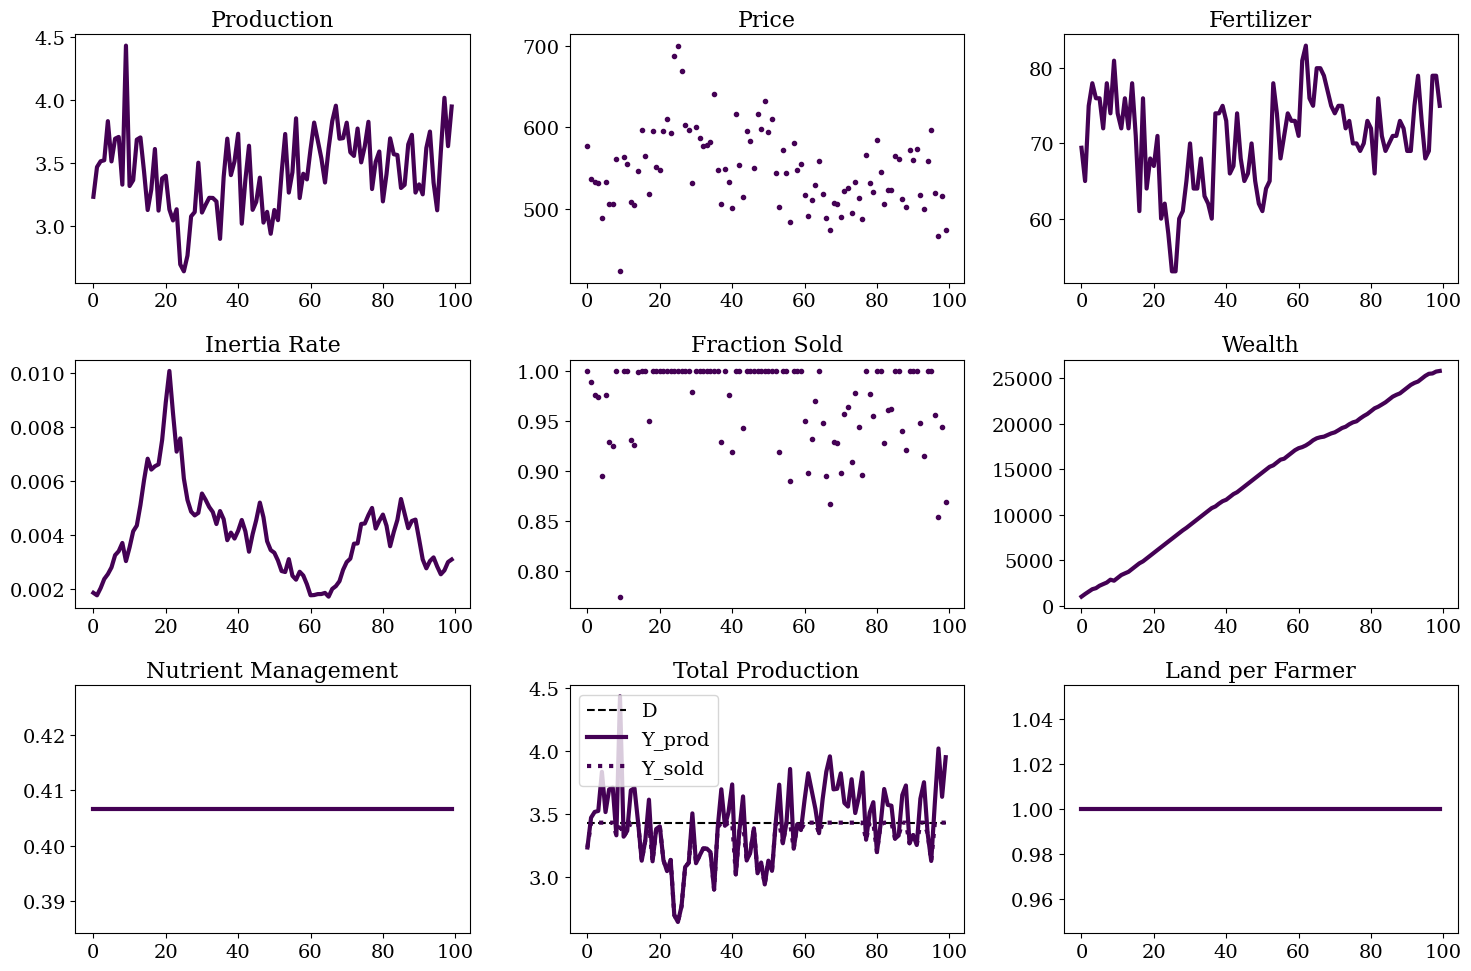

In [124]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
for i in range(size):
    ax.plot(range(num_steps), prod[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
for i in range(size):
    ax.plot(range(num_steps), price[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3)
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
for i in range(size):
    ax.plot(range(num_steps), F[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
for i in range(size):
    ax.plot(range(num_steps), inertia_rate[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Inertia Rate')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
for i in range(size):
    ax.plot(range(num_steps), wealth[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
for i in range(size):
    ax.plot(range(num_steps), fraction_sold[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.set_title('Fraction Sold')

ax = fig.add_subplot(gs[2, 0])
for i in range(size):
    ax.plot(range(num_steps), MP[:, i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, 1])
ax.plot(range(num_steps), np.sum(demand, axis=1), linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=c_matrix[0], lw = 3, label='Y_prod')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=c_matrix[-1], lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()


ax = fig.add_subplot(gs[2, 2])
for i in range(size):
    ax.plot(range(num_steps), land_per_farmer[:, i]/size, linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Land per Farmer')

# Many Farmers

Here I want to show that it works with one single farmer. 

In [10]:
ymax = 9  # Maximum achievable yield
Nr = 60  # Nutrient response parameter
p0 = 500  # Initial fixed operational cost
p1 = 1000  # Additional non operational cost
p_F = 0.8  # Price of fertilizer

num_steps = 100  # Number of simulation time steps
size = 100  # Number of farmers

omega_plus = 0.2
omega_minus = 0.2
r = 0.  # Exponent in households' utility function
beta = 10  # Land redistribution parameter
theta = 0  # Threshold wealth for farmer bankruptcy
delta = 0.1 # R&D investment fraction
demand_growth = 0.025  # Demand growth rate


In [11]:
def production(F, M):
    return ymax * (1 - np.exp(-1/Nr * (M * F))) * (1 + np.random.normal(0, 0.05, F.shape)) 

def F_optimal(previous_prod, M, p_M, fraction_sold, land_per_farmer, markup, inertia_rate, precision = 300):

    F_try = np.linspace(1, 300, precision)[:, np.newaxis]
    expected_production = land_per_farmer * production(F_try, M)
    expected_cost = (1 + markup) * land_per_farmer * ((p_F * F_try + p0) + p1)
    expected_revenues = p_M * expected_production 
    Profit_try = expected_revenues - expected_cost
    Risk_try = p_M * np.maximum(expected_production - fraction_sold * previous_prod, 0)
    Utility_try = Profit_try - inertia_rate * Risk_try**2 
    max_P_indices = np.argmax(Utility_try, axis=0)  
    F_opt = F_try[max_P_indices, np.arange(F_try.shape[1])] 
    F_opt = F_opt 

    return F_opt
    

# Arrays to store values over the simulation
F_opt = np.zeros((num_steps, size))
inertia_rate = np.zeros((num_steps, size))
F = np.zeros((num_steps, size))
prod = np.zeros((num_steps, size))
markup = np.zeros((num_steps, size))
price = np.zeros((num_steps, size))
profit = np.zeros((num_steps, size))
revenues = np.zeros((num_steps, size))
costs = np.zeros((num_steps, size))
wealth = np.zeros((num_steps, size))
fraction_sold = np.zeros((num_steps, size))
land_per_farmer = np.zeros((num_steps, size))
active_farmer = np.zeros((num_steps, size), dtype=bool)
farmer_demand = np.zeros((num_steps, size))
MP = np.zeros((num_steps, size))
research_investment = np.zeros((num_steps, size))
demand = np.zeros((num_steps, size))
households_budget = np.zeros((num_steps, size))


# Initial values
land_per_farmer[0] = 1
F[0] = np.random.uniform(low = 30, high = 90, size = size)
MP[0] = np.random.uniform(low = 0.4, high=0.5, size=size)
inertia_rate[0] = np.random.uniform(low= 0.0025, high = 0.001, size=size)
prod[0] = land_per_farmer[0] * production(F[0], MP[0])
markup[0] = 0.2
costs[0] = land_per_farmer[0] * (F[0] * p_F + p0) + p1
price[0] = (1 + markup[0]) * costs[0]/prod[0]
households_budget[0] = np.sum(land_per_farmer[0] * production(F[0], MP[0]) * price[0])
demand[0] = households_budget[0] * price[0]**(1/(r-1))/np.sum(price[0]**(r/(r-1))) 
fraction_sold[0] = 1/prod[0] * np.minimum(demand[0], prod[0])
revenues[0] = price[0] * fraction_sold[0] * prod[0]
profit[0] =  revenues[0] - costs[0]
wealth[0] = 1000
active_farmer[0] = True
research_investment[0] = 0


# Simulation loop
for t in range(1, num_steps):

    active_farmer[t] = wealth[t-1] > theta
    land_per_farmer[t] = land_per_farmer[t-1]
    MP[t] = MP[t-1]
    
    # Land market in case of bankruptcy
    prod_share = np.zeros(size)
    if np.any(wealth[t-1] < theta):
        prob = active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / (wealth[t-1, active_farmer[t]].max() - wealth[t-1, active_farmer[t]].min())) / np.sum( active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / (wealth[t-1, active_farmer[t]].max() - wealth[t-1, active_farmer[t]].min())))
        auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta])), p=prob, replace=True)
        indices, new_land = np.unique(auction_winner, return_counts=True)
        winners = np.zeros(size)
        winners[indices] = new_land
        land_per_farmer[t, winners > 0] += winners[winners > 0]
        land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta] = 0  
        prod_share = winners * np.sum(fraction_sold[t-1] * prod[t-1] * (wealth[t-1] * active_farmer[t-1] < theta))/np.sum(winners)

    # Update risk propensity based on the fraction of production sold
    inertia_rate[t, active_farmer[t]] = inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t-1, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(np.sum(active_farmer[t]))) #(1 - omega) * inertia_rate[t-1, active_farmer[t]] + omega * (1 - np.floor(fraction_sold[t-1, active_farmer[t]]))#inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t-1, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(size))#inertia_rate[t-1, active_farmer[t]] + omega * inertia_rate[t-1, active_farmer[t]] * (1 - inertia_rate[t-1, active_farmer[t]]/(1.01 - np.floor(fraction_sold[t-1, active_farmer[t]])))#
    # inertia_rate[t, active_farmer[t]] = (1 - omega) * inertia_rate[t-1, active_farmer[t]] + omega * (1 - np.floor(fraction_sold[t-1, active_farmer[t]]))

    # Determine optimal fertilizer quantity and corresponding land per farmer
    F[t, active_farmer[t]] = F_optimal(prod[t-1, active_farmer[t]] + prod_share[active_farmer[t]], MP[t,active_farmer[t]],  price[t-1, active_farmer[t]],\
                                                                fraction_sold[t-1, active_farmer[t]], land_per_farmer[t, active_farmer[t]], \
                                                                markup[t-1, active_farmer[t]], inertia_rate[t, active_farmer[t]])
    
    # Update the other farmers' variables based on the determined optimal values
    markup[t, active_farmer[t]] = markup[t-1, active_farmer[t]] 
    prod[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * production(F[t, active_farmer[t]], MP[t,active_farmer[t]])
    costs[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + p0) + p1
    price[t, active_farmer[t]] = (1 + markup[t, active_farmer[t]]) * costs[t, active_farmer[t]]/prod[t, active_farmer[t]] 

    # Allccate demand according to the CES utility function 
    demand[t, active_farmer[t]] = np.sum(demand[t-1]) * (  1 + (t <= 30) * demand_growth) * price[t,active_farmer[t]]**(1/(r-1))/np.sum(price[t,active_farmer[t]]**(1/(r-1))) 
    fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * np.minimum(prod[t,active_farmer[t]], demand[t, active_farmer[t]])

    # Compute profits and update wealth
    revenues[t, active_farmer[t]] = price[t, active_farmer[t]] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
    profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
    wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]]

    # Research and innovation investment
    research_investment[t, active_farmer[t]] = research_investment[t-1, active_farmer[t]] + delta * profit[t-1, active_farmer[t]]
    farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/500 * research_investment[t, active_farmer[t]])
    advancement = 0.1 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
    MP[t, active_farmer[t]] = MP[t, active_farmer[t]] + advancement * MP[t, active_farmer[t]]  * (1 - MP[t, active_farmer[t]])
    wealth[t, active_farmer[t]] = wealth[t, active_farmer[t]] - delta * profit[t, active_farmer[t]]

    wealth[t, np.invert(active_farmer[t])] = theta
    # inertia_rate[t, np.invert(active_farmer[t])] = 0

Text(0.5, 1.0, 'Land per Farmer')

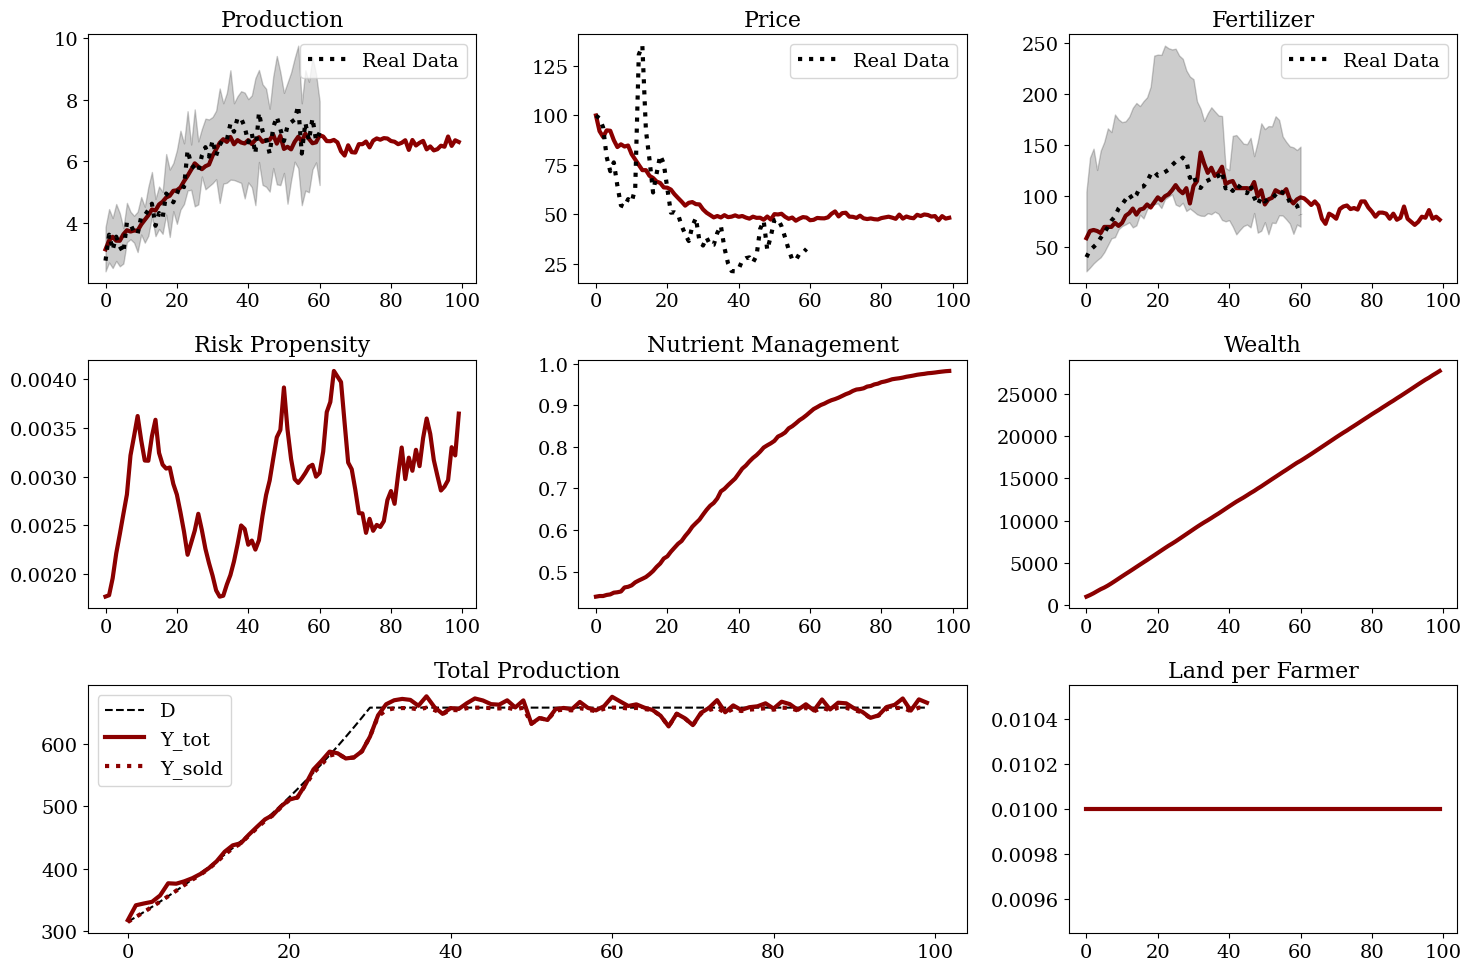

In [12]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 50
max_per = 50

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), prod[active_farmer[:,i], i]/land_per_farmer[active_farmer[:,i], i], linestyle='-', c=color, lw = 0.5)
per_50 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')


# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), price[active_farmer[:,i], i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, price, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50/per_50[0]*100, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5/per_50[0]*100, per_95/per_50[0]*100, color=color, alpha=0.2, zorder = 1)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3, zorder = 2)
df = df_list[-1]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')


# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), F[active_farmer[:,i], i], label='F', linestyle='-', c=color, lw = 0.5,zorder = 0)
per_50 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, F, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), Soil_health[active_farmer[:,i], i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Risk Propensity')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), wealth[active_farmer[:,i], i], linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), MP[active_farmer[:,i], i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, MP, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, :2])
ax.plot(range(num_steps), np.sum(demand, axis=1), linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=color, lw = 3, label = 'Y_tot')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=color, lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[2, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), land_per_farmer[active_farmer[:,i], i]/size, linestyle='-', color=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), np.sum(farmers_entering, axis=1)/size, linestyle='-', color=c_matrix[-1], lw = 3)
per_50 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), 50, axis=1)
per_5 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), min_per, axis=1)
per_95 = np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), max_per, axis=1)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Land per Farmer')

Text(0.5, 1.0, 'Land per Farmer')

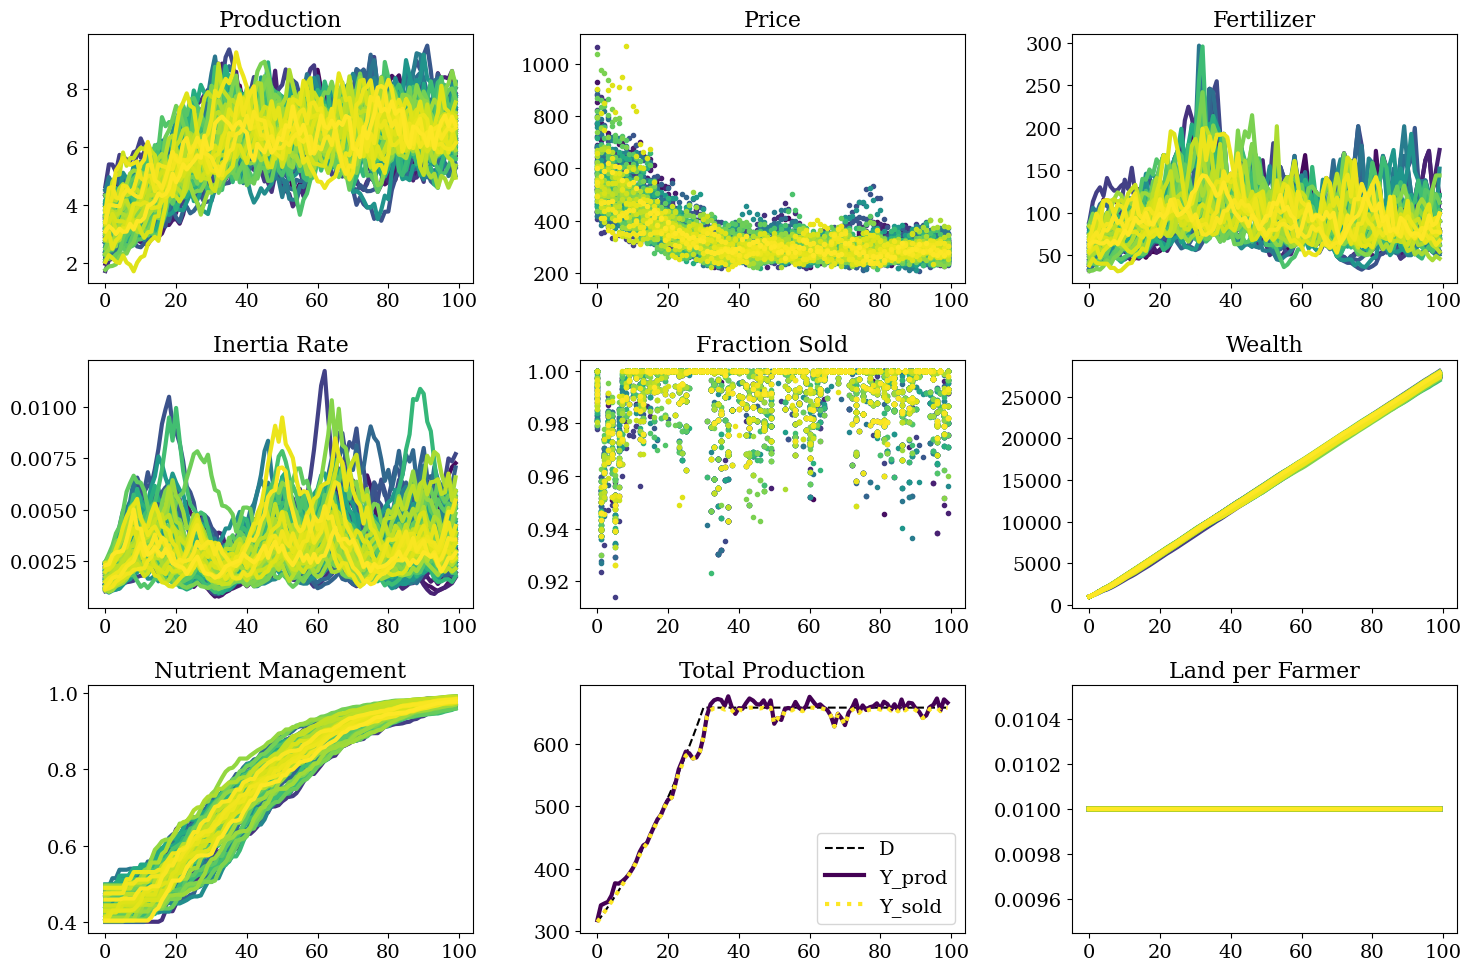

In [14]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
for i in range(size):
    ax.plot(range(num_steps), prod[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
for i in range(size):
    ax.plot(range(num_steps), price[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3)
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
for i in range(size):
    ax.plot(range(num_steps), F[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
for i in range(size):
    ax.plot(range(num_steps), inertia_rate[:, i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Inertia Rate')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
for i in range(size):
    ax.plot(range(num_steps), wealth[:, i], linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
for i in range(size):
    ax.plot(range(num_steps), fraction_sold[:, i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
ax.set_title('Fraction Sold')

ax = fig.add_subplot(gs[2, 0])
for i in range(size):
    ax.plot(range(num_steps), MP[:, i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, 1])
ax.plot(range(num_steps), np.sum(demand, axis=1), linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(prod, axis=1), linestyle='-', c=c_matrix[0], lw = 3, label='Y_prod')
ax.plot(range(num_steps), np.sum(fraction_sold * prod, axis=1), linestyle=':', c=c_matrix[-1], lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()


ax = fig.add_subplot(gs[2, 2])
for i in range(size):
    ax.plot(range(num_steps), land_per_farmer[:, i]/size, linestyle='-', marker = '', c=c_matrix[i], lw = 3)
ax.set_title('Land per Farmer')

# Montecarlo Average

In [119]:
ymax = 9  # Maximum achievable yield
Nr = 60  # Nutrient response parameter
p0 = 500  # Initial fixed operational cost
p1 = 1000  # Additional non operational cost
p_F = 0.8  # Price of fertilizer

num_steps = 100  # Number of simulation time steps
size = 100  # Number of farmers

omega_plus = 0.2
omega_minus = 0.2
r = 0.15  # Exponent in households' utility function
beta = 10  # Land redistribution parameter
theta = 0  # Threshold wealth for farmer bankruptcy
delta = 0.1 # R&D investment fraction
demand_growth = 0.025  # Demand growth rate


In [120]:
def production(F, M):
    return ymax * (1 - np.exp(-1/Nr * (M * F))) * (1 + np.random.normal(0, 0.05, F.shape)) 

def F_optimal(previous_prod, M, p_M, fraction_sold, land_per_farmer, markup, inertia_rate, precision = 300):

    F_try = np.linspace(1, 300, precision)[:, np.newaxis]
    expected_production = land_per_farmer * production(F_try, M)
    expected_cost = (1 + markup) * land_per_farmer * ((p_F * F_try + p0) + p1)
    expected_revenues = p_M * expected_production 
    Profit_try = expected_revenues - expected_cost
    Risk_try = p_M * np.maximum(expected_production - fraction_sold * previous_prod, 0)
    Utility_try = Profit_try - inertia_rate * Risk_try**2 
    max_P_indices = np.argmax(Utility_try, axis=0)  
    F_opt = F_try[max_P_indices, np.arange(F_try.shape[1])] 
    F_opt = F_opt 

    return F_opt
    

prod_list = []
price_list = []
fertilizer_list = []
risk_list = []
MP_list = []
wealth_list = []
total_prod_list = []
land_per_farmer_list = []
land_per_farmer_distribution = []

for _ in range(20):

    # Arrays to store values over the simulation
    F_opt = np.zeros((num_steps, size))
    inertia_rate = np.zeros((num_steps, size))
    F = np.zeros((num_steps, size))
    prod = np.zeros((num_steps, size))
    markup = np.zeros((num_steps, size))
    price = np.zeros((num_steps, size))
    profit = np.zeros((num_steps, size))
    revenues = np.zeros((num_steps, size))
    costs = np.zeros((num_steps, size))
    wealth = np.zeros((num_steps, size))
    fraction_sold = np.zeros((num_steps, size))
    land_per_farmer = np.zeros((num_steps, size))
    active_farmer = np.zeros((num_steps, size), dtype=bool)
    farmer_demand = np.zeros((num_steps, size))
    MP = np.zeros((num_steps, size))
    research_investment = np.zeros((num_steps, size))
    demand = np.zeros((num_steps, size))
    households_budget = np.zeros((num_steps, size))

 
    # Initial values
    land_per_farmer[0] = 1
    F[0] = np.random.uniform(low = 30, high = 90, size = size)
    MP[0] = np.random.uniform(low = 0.4, high=0.5, size=size)
    inertia_rate[0] = np.random.uniform(low= 0.0025, high = 0.001, size=size)
    prod[0] = land_per_farmer[0] * production(F[0], MP[0])
    markup[0] = 0.2
    costs[0] = land_per_farmer[0] * (F[0] * p_F + p0) + p1
    price[0] = (1 + markup[0]) * costs[0]/prod[0]
    households_budget[0] = np.sum(land_per_farmer[0] * production(F[0], MP[0]) * price[0])
    demand[0] = households_budget[0] * price[0]**(1/(r-1))/np.sum(price[0]**(r/(r-1))) 
    fraction_sold[0] = 1/prod[0] * np.minimum(demand[0], prod[0])
    revenues[0] = price[0] * fraction_sold[0] * prod[0]
    profit[0] =  revenues[0] - costs[0]
    wealth[0] = 1000
    active_farmer[0] = True
    research_investment[0] = 0


    # Simulation loop
    for t in range(1, num_steps):

        active_farmer[t] = wealth[t-1] > theta
        land_per_farmer[t] = land_per_farmer[t-1]
        MP[t] = MP[t-1]
        
        # Land market in case of bankruptcy
        prod_share = np.zeros(size)
        if np.any(wealth[t-1] < theta):
            prob = active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / (wealth[t-1, active_farmer[t]].max() - wealth[t-1, active_farmer[t]].min())) / np.sum( active_farmer[t] * np.exp(beta * (wealth[t-1] * active_farmer[t-1] - wealth[t-1, active_farmer[t]].min()) / (wealth[t-1, active_farmer[t]].max() - wealth[t-1, active_farmer[t]].min())))
            auction_winner = np.random.choice(size, int(np.sum(land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta])), p=prob, replace=True)
            indices, new_land = np.unique(auction_winner, return_counts=True)
            winners = np.zeros(size)
            winners[indices] = new_land
            land_per_farmer[t, winners > 0] += winners[winners > 0]
            land_per_farmer[t, wealth[t-1] * active_farmer[t-1] < theta] = 0  
            prod_share = winners * np.sum(fraction_sold[t-1] * prod[t-1] * (wealth[t-1] * active_farmer[t-1] < theta))/np.sum(winners)

        # Update risk propensity based on the fraction of production sold
        inertia_rate[t, active_farmer[t]] = inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t-1, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(np.sum(active_farmer[t]))) #(1 - omega) * inertia_rate[t-1, active_farmer[t]] + omega * (1 - np.floor(fraction_sold[t-1, active_farmer[t]]))#inertia_rate[t-1, active_farmer[t]] * (1 + np.where(fraction_sold[t-1, active_farmer[t]] < 1, omega_plus, -omega_minus) * np.random.rand(size))#inertia_rate[t-1, active_farmer[t]] + omega * inertia_rate[t-1, active_farmer[t]] * (1 - inertia_rate[t-1, active_farmer[t]]/(1.01 - np.floor(fraction_sold[t-1, active_farmer[t]])))#
        # inertia_rate[t, active_farmer[t]] = (1 - omega) * inertia_rate[t-1, active_farmer[t]] + omega * (1 - np.floor(fraction_sold[t-1, active_farmer[t]]))

        # Determine optimal fertilizer quantity and corresponding land per farmer
        F[t, active_farmer[t]] = F_optimal(prod[t-1, active_farmer[t]] + prod_share[active_farmer[t]], MP[t,active_farmer[t]],  price[t-1, active_farmer[t]],\
                                                                    fraction_sold[t-1, active_farmer[t]], land_per_farmer[t, active_farmer[t]], \
                                                                    markup[t-1, active_farmer[t]], inertia_rate[t, active_farmer[t]])
        
        # Update the other farmers' variables based on the determined optimal values
        markup[t, active_farmer[t]] = markup[t-1, active_farmer[t]] 
        prod[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * production(F[t, active_farmer[t]], MP[t,active_farmer[t]])
        costs[t, active_farmer[t]] = land_per_farmer[t, active_farmer[t]] * (F[t, active_farmer[t]] * p_F + p0) + p1
        price[t, active_farmer[t]] = (1 + markup[t, active_farmer[t]]) * costs[t, active_farmer[t]]/prod[t, active_farmer[t]] 

        # Allccate demand according to the CES utility function 
        demand[t, active_farmer[t]] = np.sum(demand[t-1]) * (  1 + (t <= 30) * demand_growth) * price[t,active_farmer[t]]**(1/(r-1))/np.sum(price[t,active_farmer[t]]**(1/(r-1))) 
        fraction_sold[t, active_farmer[t]] = 1/prod[t, active_farmer[t]] * np.minimum(prod[t,active_farmer[t]], demand[t, active_farmer[t]])

        # Compute profits and update wealth
        revenues[t, active_farmer[t]] = price[t, active_farmer[t]] * fraction_sold[t, active_farmer[t]] * prod[t, active_farmer[t]]
        profit[t, active_farmer[t]] =  revenues[t, active_farmer[t]] - costs[t, active_farmer[t]]
        wealth[t, active_farmer[t]] = wealth[t-1, active_farmer[t]] + profit[t, active_farmer[t]]

        # Research and innovation investment
        research_investment[t, active_farmer[t]] = research_investment[t-1, active_farmer[t]] + delta * profit[t-1, active_farmer[t]]
        farms_innovating = np.random.rand(np.sum(active_farmer[t])) < 1 - np.exp(- 1/500 * research_investment[t, active_farmer[t]])
        advancement = 0.1 * np.random.rand(np.sum(active_farmer[t])) * farms_innovating
        MP[t, active_farmer[t]] = MP[t, active_farmer[t]] + advancement * MP[t, active_farmer[t]]  * (1 - MP[t, active_farmer[t]])
        wealth[t, active_farmer[t]] = wealth[t, active_farmer[t]] - delta * profit[t, active_farmer[t]]

        wealth[t, np.invert(active_farmer[t])] = theta
        # inertia_rate[t, np.invert(active_farmer[t])] = 0

    prod_list.append(np.nanpercentile(np.where(active_farmer == True, prod/land_per_farmer, np.nan), 50, axis=1))
    price_list.append(np.nanpercentile(np.where(active_farmer == True, price, np.nan), 50, axis=1))
    fertilizer_list.append(np.nanpercentile(np.where(active_farmer == True, F, np.nan), 50, axis=1))
    risk_list.append(np.nanpercentile(np.where(active_farmer == True, inertia_rate, np.nan), 50, axis=1))
    MP_list.append(np.nanpercentile(np.where(active_farmer == True, MP, np.nan), 50, axis=1))
    wealth_list.append(np.nanpercentile(np.where(active_farmer == True, wealth, np.nan), 50, axis=1))
    total_prod_list.append(np.sum(prod, axis=1))
    land_per_farmer_list.append(np.nanpercentile(np.where(active_farmer == True, land_per_farmer/size, np.nan), 50, axis=1))
    land_per_farmer_distribution.append(land_per_farmer[-1, active_farmer[-1]])

Text(0.5, 1.0, 'Land per Farmer')

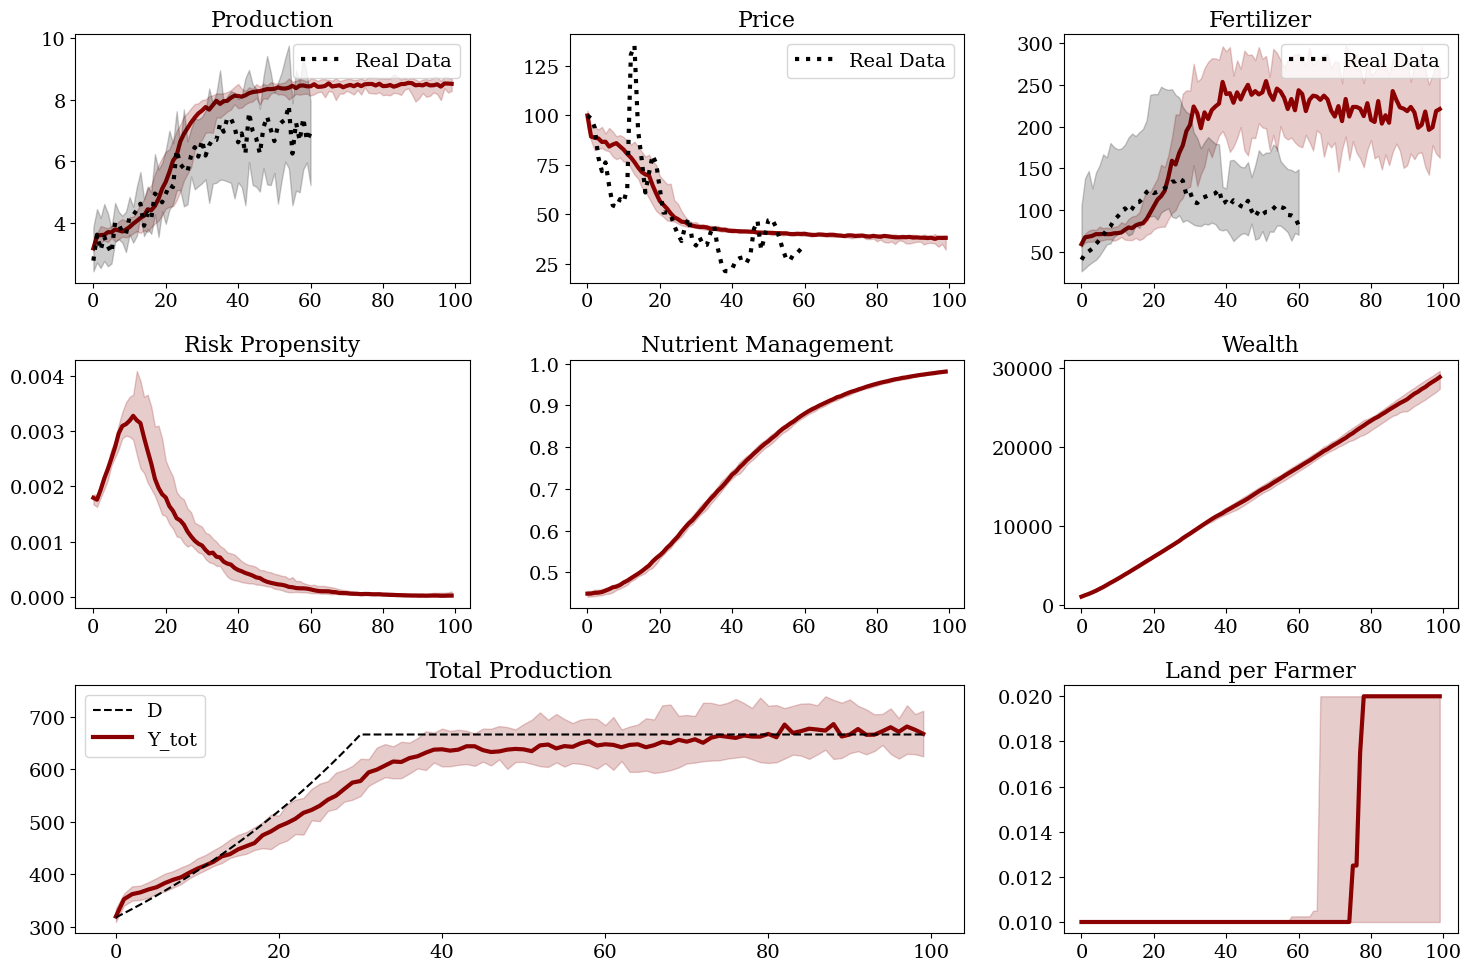

In [121]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=3, ncols=3)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 5
max_per = 95

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
per_50 = np.nanpercentile(np.array(prod_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(prod_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(prod_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')


# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), price[active_farmer[:,i], i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.array(price_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(price_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(price_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50/per_50[0]*100, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5/per_50[0]*100, per_95/per_50[0]*100, color=color, alpha=0.2, zorder = 1)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3, zorder = 2)
df = df_list[-1]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')


# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), F[active_farmer[:,i], i], label='F', linestyle='-', c=color, lw = 0.5,zorder = 0)
per_50 = np.nanpercentile(np.array(fertilizer_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(fertilizer_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(fertilizer_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), Soil_health[active_farmer[:,i], i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.array(risk_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(risk_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(risk_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Risk Propensity')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), wealth[active_farmer[:,i], i], linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.array(wealth_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(wealth_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(wealth_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), MP[active_farmer[:,i], i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.array(MP_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(MP_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(MP_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, :2])
per_50 = np.nanpercentile(np.array(total_prod_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(total_prod_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(total_prod_list), max_per, axis=0)
ax.plot(range(num_steps), np.sum(demand, axis=1), linestyle='--', color='k', label ='D')
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1, label = 'Y_tot')
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[2, 2])
# for i in range(size):
#     ax.plot(range(np.sum(active_farmer[:,i])), land_per_farmer[active_farmer[:,i], i]/size, linestyle='-', color=c_matrix[i], lw = 3)
# ax.plot(range(num_steps), np.sum(farmers_entering, axis=1)/size, linestyle='-', color=c_matrix[-1], lw = 3)
per_50 = np.nanpercentile(np.array(land_per_farmer_list), 50, axis=0)
per_5 = np.nanpercentile(np.array(land_per_farmer_list), min_per, axis=0)
per_95 = np.nanpercentile(np.array(land_per_farmer_list), max_per, axis=0)
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Land per Farmer')